## 理想のLPFと実際のLPF

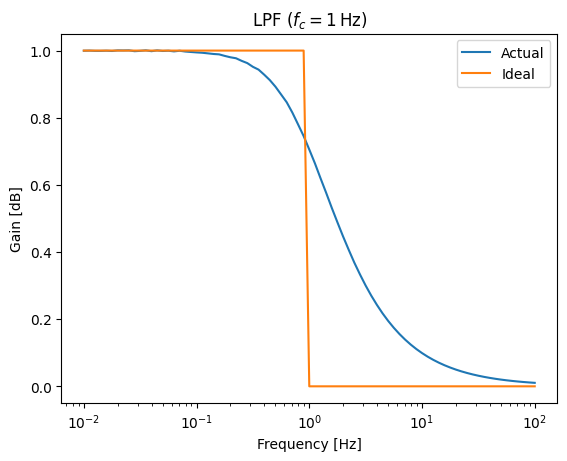

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from numba import jit, prange

# モデル設定
dt = 1e-2
tau = 1
alfa = tau / (tau + dt)
f_cut = 1 / (2 * np.pi * tau)
omega_cut = 2 * np.pi * f_cut

x_low = -2
x_high = 2
x_slice = 20
num = x_slice * (x_high - x_low) + 1
exp = np.logspace(x_low, x_high, num)

@jit(nopython=True, cache=True, fastmath=True, nogil=True)
def calc_first_order(f, alfa):
  y = np.empty_like(f)
  y[0] = f[0]
  for i in range(1, len(f)):
    y[i] = alfa * y[i-1] + (1 - alfa) * f[i]
  return y

@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def calc_amp(f, y):
  return np.abs(y).mean() / np.abs(f).mean()

@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def f(exp, alfa, dt):
  t = np.arange(0, 2400, dt)
  half = len(t) // 4 * 3
  amp = np.empty_like(exp)
  for j in prange(len(exp)):
    omega = exp[j]
    f = np.sin(omega * t)
    y = calc_first_order(f, alfa)
    amp[j] = calc_amp(f[half:], y[half:])
  return amp

@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def ideal(exp, omega_cutoff):
  amp = np.zeros_like(exp)
  amp[exp < omega_cutoff] = 1
  return amp

amp = f(exp, alfa, dt)

plt.figure()
plt.title(r"LPF ($f_c = 1\,\mathrm{Hz}$)")
plt.gca().set_xscale('log')
plt.plot(exp, amp, label="Actual")
plt.plot(exp, ideal(exp, omega_cut), label="Ideal")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Gain [dB]")

plt.legend()

plt.show()